# Building a song recommender

I obtained the datasets from https://static.turi.com/datasets/millionsong/10000.txt and https://static.turi.com/datasets/millionsong/song_data.csv. I later wrote the files to two different csv "song_1.csv" and "song_2.csv" files then merged them into one data frames which I also wrote to a csv file "Songs.csv"

In [1]:
%matplotlib inline

import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
import joblib
import matplotlib.pyplot as plt
import Recommenders as Recommenders
import Evaluation as Evaluation

# Load music data

In [2]:
#Read userid-songid-listen_count triplets
#This step might take time to download data from external sources
triplets_file = 'https://static.turi.com/datasets/millionsong/10000.txt'
songs_metadata_file = 'https://static.turi.com/datasets/millionsong/song_data.csv'

song_df_1 = pandas.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 =  pandas.read_csv(songs_metadata_file)

#Merge the two dataframes above to create input dataframe for recommender systems
song_df = pandas.merge(song_df_1, song_df_2.drop_duplicates(['song_id']), on="song_id", how="left") 

# Explore Data Analysis

Music data shows how many times a user listened to a song, as well as the details of the song.

## Data Exploration

### View the first five rows of the dataset

In [3]:
song_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


### Size of the Dataset

In [4]:
song_df.shape

(2000000, 7)

### Identification of data types

In [5]:
song_df.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

### Data Info

In [6]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
 3   title         object
 4   release       object
 5   artist_name   object
 6   year          int64 
dtypes: int64(2), object(5)
memory usage: 122.1+ MB


In [7]:
import pandas as pd
song_df['year'] = song_df['year'].astype('object')

## Stastical Summary of the Numeric Variables

In [8]:
song_df.describe()

,listen_count
count,2.000000e+06
mean,3.045485e+00
std,6.579720e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,2.213000e+03


## Non-Graphical Univariate Analysis
### To get the count of unique values

In [9]:
song_df['artist_name'].value_counts()

Coldplay                  29422
The Black Keys            19862
Kings Of Leon             18747
Florence + The Machine    18112
Jack Johnson              17801
                          ...  
Shotta                       54
Umphrey's McGee              52
The Four Seasons             52
Ricardo Montaner             52
Amparanoia                   50
Name: artist_name, Length: 3375, dtype: int64

### list & number of unique values

In [10]:
song_df.nunique()

user_id         76353
song_id         10000
listen_count      295
title            9567
release          5388
artist_name      3375
year               58
dtype: int64

In [11]:
# Unique values in year
song_df['year'].unique()

array([0, 1976, 2007, 2005, 1999, 2008, 2002, 1989, 2009, 2001, 2006,
       2003, 1997, 2010, 1968, 1986, 1963, 1982, 1991, 1998, 1967, 1981,
       1974, 1984, 2004, 2000, 1988, 1990, 1994, 1996, 1995, 1983, 1993,
       1978, 1987, 1979, 1985, 1975, 1992, 1965, 1962, 1972, 1977, 1980,
       1969, 1964, 1973, 1960, 1970, 1971, 1966, 1956, 1954, 1959, 1958,
       1955, 1957, 1961], dtype=object)

### Filtering based on conditions

#### Check out the songs released by Coldplay

In [12]:
song_df[song_df['artist_name']=='Coldplay']

,user_id,song_id,listen_count,title,release,artist_name,year
113,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOAUBGU12A6701C57A,2,Swallowed In The Sea,X & Y,Coldplay,2005
114,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOCLQES12A58A7BB1D,2,Life In Technicolor,Viva La Vida Or Death And All His Friends,Coldplay,2008
115,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOCVTLJ12A6310F0FD,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
116,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOEWTBE12A58A7E7C2,2,Strawberry Swing,Viva La Vida - Prospekt's March Edition,Coldplay,2008
117,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOICNON12A8C140437,4,Life In Technicolor ii,Viva La Vida - Prospekt's March Edition,Coldplay,2008
...,...,...,...,...,...,...,...
1999174,b414946179d4921689dfd7e68aba679080bfcd33,SOMRYYN12A6310F0F3,1,In My Place,A Rush Of Blood To The Head,Coldplay,2001
1999775,9116c65d75343f5ac19f27b2eb8b1b447855e2ba,SOCVTLJ12A6310F0FD,11,Clocks,A Rush Of Blood To The Head,Coldplay,2002
1999881,391de020bddab59d1927ff4884cbebf8797df289,SOPXKYD12A6D4FA876,1,Yellow,Yellow,Coldplay,2000
1999882,391de020bddab59d1927ff4884cbebf8797df289,SOSEBVP12A6D4F9CBB,5,Amsterdam,A Rush Of Blood To The Head,Coldplay,2002


#### View the songs released by Coldplay with title clocks

In [13]:
song_df[(song_df['artist_name']=='Coldplay')&(song_df['title']=='Clocks')]

,user_id,song_id,listen_count,title,release,artist_name,year
115,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,SOCVTLJ12A6310F0FD,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
396,5a905f000fc1ff3df7ca807d57edb608863db05d,SOCVTLJ12A6310F0FD,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
916,bd8475385f0aa78830fa6dfce9e7242164b035c8,SOCVTLJ12A6310F0FD,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
1192,a58de017cbeda1763ea002fe027ed41b4ed53109,SOCVTLJ12A6310F0FD,6,Clocks,A Rush Of Blood To The Head,Coldplay,2002
1648,930d2be6c85315d72cab9823ec0f7bfe7e477794,SOCVTLJ12A6310F0FD,1,Clocks,A Rush Of Blood To The Head,Coldplay,2002
...,...,...,...,...,...,...,...
1997290,825be7a0129032693e8a897e961b21720c66a0a2,SOCVTLJ12A6310F0FD,2,Clocks,A Rush Of Blood To The Head,Coldplay,2002
1998840,6af523b1dff77e4269f5f575698c539966665060,SOCVTLJ12A6310F0FD,1,Clocks,A Rush Of Blood To The Head,Coldplay,2002
1998965,fdd00cc848e2ba64f45c869275b0d590a5f9c97f,SOCVTLJ12A6310F0FD,1,Clocks,A Rush Of Blood To The Head,Coldplay,2002
1999775,9116c65d75343f5ac19f27b2eb8b1b447855e2ba,SOCVTLJ12A6310F0FD,11,Clocks,A Rush Of Blood To The Head,Coldplay,2002


#### Filter songs released by Amparanoia                   

In [14]:
song_df[song_df['artist_name']=='Amparanoia']

,user_id,song_id,listen_count,title,release,artist_name,year
39859,ae42b23c02139ca2fcaf97de0166675d303ff89c,SOBPGWB12A6D4F7EF3,19,Don´t Leave Me Now,Enchilao,Amparanoia,2003
82043,476081b0f3867e7f08f9a5ba2945848f8ddb3712,SOBPGWB12A6D4F7EF3,29,Don´t Leave Me Now,Enchilao,Amparanoia,2003
96636,ae5955b6dd94210abfc98df818b8f3eb572e2ca9,SOBPGWB12A6D4F7EF3,10,Don´t Leave Me Now,Enchilao,Amparanoia,2003
178302,67be5bbaf9e0989536d22ea60e1b617d8c565dda,SOBPGWB12A6D4F7EF3,1,Don´t Leave Me Now,Enchilao,Amparanoia,2003
189084,d805b8eef3d8fcb90379cd523da90b157066047d,SOBPGWB12A6D4F7EF3,1,Don´t Leave Me Now,Enchilao,Amparanoia,2003
213281,ee7aa84c164038c963cfd02a7e52a5598aa470c3,SOBPGWB12A6D4F7EF3,3,Don´t Leave Me Now,Enchilao,Amparanoia,2003
260444,1cfddc9c38f6077449b30726cfd0ae8345edf11a,SOBPGWB12A6D4F7EF3,1,Don´t Leave Me Now,Enchilao,Amparanoia,2003
261941,1fc2889d74870cdc2cca5eeca47ec9dab016274c,SOBPGWB12A6D4F7EF3,5,Don´t Leave Me Now,Enchilao,Amparanoia,2003
318576,638bbafa728e8865d627d7fdc48d3e1d4903f257,SOBPGWB12A6D4F7EF3,1,Don´t Leave Me Now,Enchilao,Amparanoia,2003
330633,da7c3cbbba870a3f18834dfc093a64d6e158eb77,SOBPGWB12A6D4F7EF3,1,Don´t Leave Me Now,Enchilao,Amparanoia,2003


### Get Null Values

In [15]:
song_df.apply(lambda x: sum(x.isnull ()), axis=0)

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

## Graphical Univariate Analysis

### Distribution of Listen Count

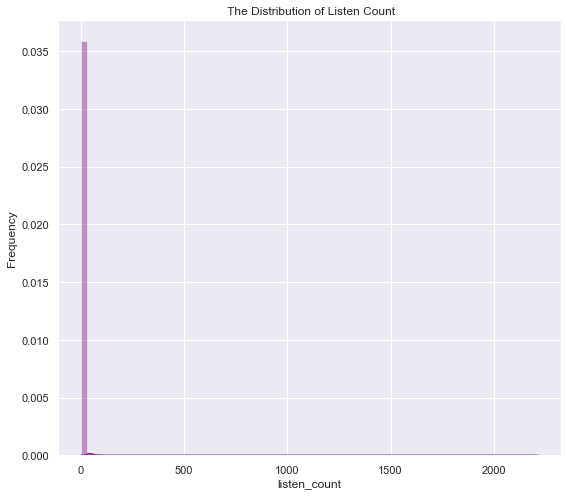

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(9, 8))
sns.distplot(song_df['listen_count'], color='purple', bins=80, hist_kws = {'alpha': 0.4})
plt.title(" The Distribution of Listen Count")
plt.ylabel('Frequency')
plt.show()

In [17]:
song_df_number = song_df.select_dtypes(include=['float64', 'int64'])

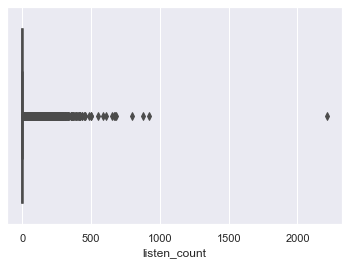

In [18]:
sns.boxplot(x='listen_count', data=song_df)

### Count plots 

Text(0.5, 1.0, 'The listen count in each from the year 1954 to 2010')

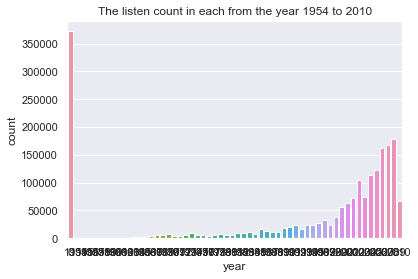

In [19]:
%matplotlib inline
sns.set()

sns.countplot(song_df['year'])
plt.title("The listen count in each from the year 1954 to 2010")

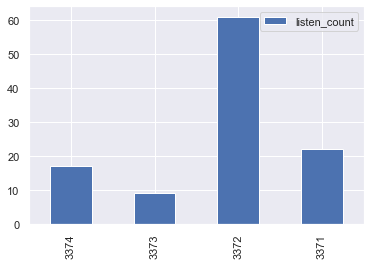

In [20]:
byListenCount = song_df[['artist_name', 'listen_count']].groupby('artist_name').max().reset_index()
byListenCount.sort_values(by = 'artist_name', ascending=False).head(4).plot(kind='bar')

## Length of the dataset

In [21]:
len(song_df)

2000000

## Create a subset of the dataset

In [22]:
song_df = song_df.head(10000)

#Merge song title and artist_name columns to make a merged column
song_df['song'] = song_df['title'].map(str) + " - " + song_df['artist_name']

## Showing the most popular songs in the dataset

In [23]:
song_grouped = song_df.groupby(['song']).agg({'listen_count': 'count'}).reset_index()
grouped_sum = song_grouped['listen_count'].sum()
song_grouped['percentage']  = song_grouped['listen_count'].div(grouped_sum)*100
song_grouped.sort_values(['listen_count', 'song'], ascending = [0,1])

,song,listen_count,percentage
3660,Sehr kosmisch - Harmonia,45,0.45
4678,Undo - Björk,32,0.32
5105,You're The One - Dwight Yoakam,32,0.32
1071,Dog Days Are Over (Radio Edit) - Florence + Th...,28,0.28
3655,Secrets - OneRepublic,28,0.28
...,...,...,...
5139,high fives - Four Tet,1,0.01
5140,in white rooms - Booka Shade,1,0.01
5143,paranoid android - Christopher O'Riley,1,0.01
5149,¿Lo Ves? [Piano Y Voz] - Alejandro Sanz,1,0.01


## Count number of unique users in the dataset

In [24]:
users = song_df['user_id'].unique()

In [25]:
len(users)

365

## Quiz 1. Count the number of unique songs in the dataset

In [26]:
###Fill in the code here
songs = song_df['song'].unique()
len(songs)

5151

# Create a song recommender

In [27]:
train_data, test_data = train_test_split(song_df, test_size = 0.20, random_state=0)
print(train_data.head(5))

                                       user_id             song_id  \
7389  94d5bdc37683950e90c56c9b32721edb5d347600  SOXNZOW12AB017F756   
9275  1012ecfd277b96487ed8357d02fa8326b13696a5  SOXHYVQ12AB0187949   
2995  15415fa2745b344bce958967c346f2a89f792f63  SOOSZAZ12A6D4FADF8   
5316  ffadf9297a99945c0513cd87939d91d8b602936b  SOWDJEJ12A8C1339FE   
356   5a905f000fc1ff3df7ca807d57edb608863db05d  SOAMPRJ12A8AE45F38   

      listen_count                 title  \
7389             2      Half Of My Heart   
9275             1  The Beautiful People   
2995             1     Sanctify Yourself   
5316             4     Heart Cooks Brain   
356             20                 Rorol   

                                                release      artist_name  \
7389                                     Battle Studies       John Mayer   
9275             Antichrist Superstar (Ecopac Explicit)   Marilyn Manson   
2995                             Glittering Prize 81/92     Simple Minds   
5316  Ever

## Simple popularity-based recommender class (Can be used as a black box)

In [28]:
#Recommenders.popularity_recommender_py

### Create an instance of popularity based recommender class

In [29]:
pm = Recommenders.popularity_recommender_py()
pm.create(train_data, 'user_id', 'song')

### Use the popularity model to make some predictions

In [30]:
user_id = users[5]
pm.recommend(user_id)

,user_id,song,score,Rank
3194,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Sehr kosmisch - Harmonia,37,1.0
4083,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Undo - Björk,27,2.0
931,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,4bd88bfb25263a75bbdd467e74018f4ae570e5df,You're The One - Dwight Yoakam,24,4.0
3034,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Revelry - Kings Of Leon,21,5.0
3189,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Secrets - OneRepublic,21,6.0
4112,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Use Somebody - Kings Of Leon,21,7.0
1207,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Fireflies - Charttraxx Karaoke,20,8.0
1577,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hey_ Soul Sister - Train,19,9.0
1626,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


### Quiz 2: Use the popularity based model to make predictions for the following user id (Note the difference in recommendations from the first user id).

In [31]:
###Fill in the code here
user_id = users[8]
pm.recommend(user_id)


,user_id,song,score,Rank
3194,9bb911319fbc04f01755814cb5edb21df3d1a336,Sehr kosmisch - Harmonia,37,1.0
4083,9bb911319fbc04f01755814cb5edb21df3d1a336,Undo - Björk,27,2.0
931,9bb911319fbc04f01755814cb5edb21df3d1a336,Dog Days Are Over (Radio Edit) - Florence + Th...,24,3.0
4443,9bb911319fbc04f01755814cb5edb21df3d1a336,You're The One - Dwight Yoakam,24,4.0
3034,9bb911319fbc04f01755814cb5edb21df3d1a336,Revelry - Kings Of Leon,21,5.0
3189,9bb911319fbc04f01755814cb5edb21df3d1a336,Secrets - OneRepublic,21,6.0
4112,9bb911319fbc04f01755814cb5edb21df3d1a336,Use Somebody - Kings Of Leon,21,7.0
1207,9bb911319fbc04f01755814cb5edb21df3d1a336,Fireflies - Charttraxx Karaoke,20,8.0
1577,9bb911319fbc04f01755814cb5edb21df3d1a336,Hey_ Soul Sister - Train,19,9.0
1626,9bb911319fbc04f01755814cb5edb21df3d1a336,Horn Concerto No. 4 in E flat K495: II. Romanc...,19,10.0


## Build a song recommender with personalization

We now create an item similarity based collaborative filtering model that allows us to make personalized recommendations to each user. 

## Class for an item similarity based personalized recommender system (Can be used as a black box)

In [32]:
#Recommenders.item_similarity_recommender_py

### Create an instance of item similarity based recommender class

In [33]:
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data, 'user_id', 'song')

### Use the personalized model to make some song recommendations

In [34]:
#Print the songs for the user in training data
user_id = users[5]
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)

------------------------------------------------------------------------------------
Training data songs for the user userid: 4bd88bfb25263a75bbdd467e74018f4ae570e5df:
------------------------------------------------------------------------------------
Just Lose It - Eminem
Without Me - Eminem
16 Candles - The Crests
Speechless - Lady GaGa
Push It - Salt-N-Pepa
Ghosts 'n' Stuff (Original Instrumental Mix) - Deadmau5
Say My Name - Destiny's Child
My Dad's Gone Crazy - Eminem / Hailie Jade
The Real Slim Shady - Eminem
Somebody To Love - Justin Bieber
Forgive Me - Leona Lewis
Missing You - John Waite
Ya Nada Queda - Kudai
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 13
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :2097


,user_id,song,score,rank
0,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Superman - Eminem / Dina Rae,0.088692,1
1,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Mockingbird - Eminem,0.067663,2
2,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm Back - Eminem,0.065385,3
3,4bd88bfb25263a75bbdd467e74018f4ae570e5df,U Smile - Justin Bieber,0.064525,4
4,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Here Without You - 3 Doors Down,0.062293,5
5,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Hellbound - J-Black & Masta Ace,0.055769,6
6,4bd88bfb25263a75bbdd467e74018f4ae570e5df,The Seed (2.0) - The Roots / Cody Chestnutt,0.052564,7
7,4bd88bfb25263a75bbdd467e74018f4ae570e5df,I'm The One Who Understands (Edit Version) - War,0.052564,8
8,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Falling - Iration,0.052564,9
9,4bd88bfb25263a75bbdd467e74018f4ae570e5df,Armed And Ready (2009 Digital Remaster) - The ...,0.052564,10


### Quiz 3. Use the personalized model to make recommendations for the following user id. (Note the difference in recommendations from the first user id.)

In [35]:
user_id = users[7]
#Fill in the code here
user_items = is_model.get_user_items(user_id)
#
print("------------------------------------------------------------------------------------")
print("Training data songs for the user userid: %s:" % user_id)
print("------------------------------------------------------------------------------------")

for user_item in user_items:
    print(user_item)

print("----------------------------------------------------------------------")
print("Recommendation process going on:")
print("----------------------------------------------------------------------")

#Recommend songs for the user using personalized model
is_model.recommend(user_id)


------------------------------------------------------------------------------------
Training data songs for the user userid: 9d6f0ead607ac2a6c2460e4d14fb439a146b7dec:
------------------------------------------------------------------------------------
Swallowed In The Sea - Coldplay
Life In Technicolor ii - Coldplay
Life In Technicolor - Coldplay
The Scientist - Coldplay
Trouble - Coldplay
Strawberry Swing - Coldplay
Lost! - Coldplay
Clocks - Coldplay
----------------------------------------------------------------------
Recommendation process going on:
----------------------------------------------------------------------
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :3429


,user_id,song,score,rank
0,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,She Just Likes To Fight - Four Tet,0.281579,1
1,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Warning Sign - Coldplay,0.281579,2
2,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,We Never Change - Coldplay,0.281579,3
3,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Puppetmad - Puppetmastaz,0.281579,4
4,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,God Put A Smile Upon Your Face - Coldplay,0.281579,5
5,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Susie Q - Creedence Clearwater Revival,0.281579,6
6,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,The Joker - Fatboy Slim,0.281579,7
7,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,Korg Rhythm Afro - Holy Fuck,0.281579,8
8,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,This Unfolds - Four Tet,0.281579,9
9,9d6f0ead607ac2a6c2460e4d14fb439a146b7dec,high fives - Four Tet,0.281579,10


### We can also apply the model to find similar songs to any song in the dataset

In [36]:
is_model.get_similar_items(['U Smile - Justin Bieber'])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :271


,user_id,song,score,rank
0,,Somebody To Love - Justin Bieber,0.428571,1
1,,Bad Company - Five Finger Death Punch,0.375000,2
2,,Love Me - Justin Bieber,0.333333,3
3,,One Time - Justin Bieber,0.333333,4
4,,Here Without You - 3 Doors Down,0.333333,5
5,,Stuck In The Moment - Justin Bieber,0.333333,6
6,,Teach Me How To Dougie - California Swag District,0.333333,7
7,,Paper Planes - M.I.A.,0.333333,8
8,,Already Gone - Kelly Clarkson,0.333333,9
9,,The Funeral (Album Version) - Band Of Horses,0.300000,10


### Quiz 4. Use the personalized recommender model to get similar songs for the following song.

In [37]:
song = 'Yellow - Coldplay'
###Fill in the code here
is_model.get_similar_items([song])

no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :969


,user_id,song,score,rank
0,,Fix You - Coldplay,0.375000,1
1,,Creep (Explicit) - Radiohead,0.291667,2
2,,Clocks - Coldplay,0.280000,3
3,,Seven Nation Army - The White Stripes,0.250000,4
4,,Paper Planes - M.I.A.,0.208333,5
5,,Halo - Beyoncé,0.200000,6
6,,The Funeral (Album Version) - Band Of Horses,0.181818,7
7,,In My Place - Coldplay,0.181818,8
8,,Kryptonite - 3 Doors Down,0.166667,9
9,,When You Were Young - The Killers,0.166667,10


# Quantitative comparison between the models

We now formally compare the popularity and the personalized models using precision-recall curves. 

## Class to calculate precision and recall (This can be used as a black box)

In [38]:
#Evaluation.precision_recall_calculator

## Use the above precision recall calculator class to calculate the evaluation measures

In [39]:
start = time.time()

#Define what percentage of users to use for precision recall calculation
user_sample = 0.05

#Instantiate the precision_recall_calculator class
pr = Evaluation.precision_recall_calculator(test_data, train_data, pm, is_model)

#Call method to calculate precision and recall values
(pm_avg_precision_list, pm_avg_recall_list, ism_avg_precision_list, ism_avg_recall_list) = pr.calculate_measures(user_sample)

end = time.time()
print(end - start)

Length of user_test_and_training:319
Length of user sample:15
Getting recommendations for user:baf47ed8da24d607e50d8684cde78b923538640f
No. of unique songs for the user: 84
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :10714
Getting recommendations for user:bd8475385f0aa78830fa6dfce9e7242164b035c8
No. of unique songs for the user: 109
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :27912
Getting recommendations for user:8bde0ae3eda6b6f26c8a91eb5750d416acb3d508
No. of unique songs for the user: 26
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :4329
Getting recommendations for user:6251be155cbf0728f2528bb02951e0bc6c11acb2
No. of unique songs for the user: 8
no. of unique songs in the training set: 4483
Non zero values in cooccurence_matrix :1178
Getting recommendations for user:93daed66184da1bf172e853c537f72ec93294fab
No. of unique songs for the user: 12
no. of unique songs i

## Code to plot precision recall curve

In [40]:
import pylab as pl

#Method to generate precision and recall curve
def plot_precision_recall(m1_precision_list, m1_recall_list, m1_label, m2_precision_list, m2_recall_list, m2_label):
    pl.clf()    
    pl.plot(m1_recall_list, m1_precision_list, label=m1_label)
    pl.plot(m2_recall_list, m2_precision_list, label=m2_label)
    pl.xlabel('Recall')
    pl.ylabel('Precision')
    pl.ylim([0.0, 0.20])
    pl.xlim([0.0, 0.20])
    pl.title('Precision-Recall curve')
    #pl.legend(loc="upper right")
    pl.legend(loc=9, bbox_to_anchor=(0.5, -0.2))
    pl.show()


Plotting precision recall curves.


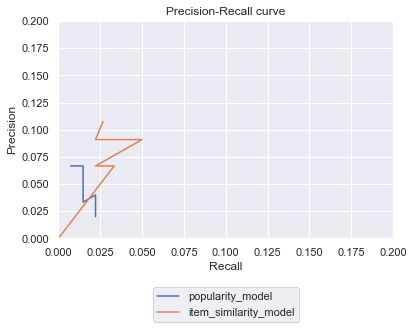

In [41]:
print("Plotting precision recall curves.")

plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")


### Generate Precision Recall curve using pickled results on a larger data subset(Python 3)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


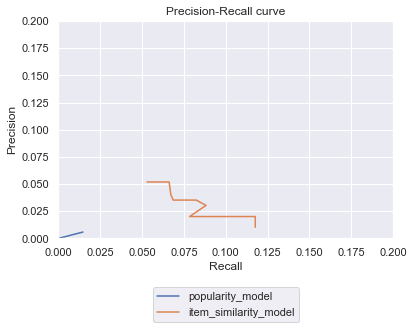

In [42]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

#Read the persisted files 
pm_avg_precision_list = joblib.load('pm_avg_precision_list_3.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_3.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_3.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_3.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

### Generate Precision Recall curve using pickled results on a larger data subset(Python 2.7)

Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).
Plotting precision recall curves.


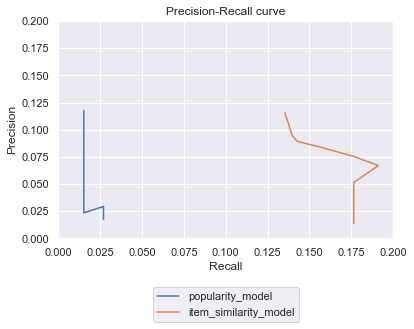

In [43]:
print("Plotting precision recall curves for a larger subset of data (100,000 rows) (user sample = 0.005).")

pm_avg_precision_list = joblib.load('pm_avg_precision_list_2.pkl')
pm_avg_recall_list = joblib.load('pm_avg_recall_list_2.pkl')
ism_avg_precision_list = joblib.load('ism_avg_precision_list_2.pkl')
ism_avg_recall_list = joblib.load('ism_avg_recall_list_2.pkl')

print("Plotting precision recall curves.")
plot_precision_recall(pm_avg_precision_list, pm_avg_recall_list, "popularity_model",
                      ism_avg_precision_list, ism_avg_recall_list, "item_similarity_model")

The curve shows that the personalized model provides much better performance over the popularity model. 